In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from matplotlib.ticker import MaxNLocator

In [3]:
def sortKey(data: dict, reverse=False):
    '''
    Sort dictionary based on key
    '''
    return dict(sorted(data.items(), key=lambda x: x[0], reverse=reverse))

def sortValue(data: dict, reverse=False):
    '''
    Sort dictionary based on value
    '''
    return dict(sorted(data.items(), key=lambda x: x[1], reverse=reverse))

def getTopElements(data: dict, num_element: int, top_most=True):
    '''
    Get top-K elements in a dictionary

    Args:
        data: a dictionary to store data
        num_element: K (int)
        top_most: True if top-K is located at the beginning of data, 
                False if top-K is located at the end of data

    Returns:
        Top-K elements (dict)
    '''
    
    if top_most:
        return {k: data[k] for k in list(data)[:num_element]}
    return {k: data[k] for k in list(data)[-num_element:]}

### 1. Basic information

In [4]:
meal_table = pd.read_csv('meal.csv')

In [5]:
recipe_table = pd.read_csv('recipe.csv')

In [6]:
user_meal = pd.read_csv('user_meal.csv')

In [7]:
user_recipe = pd.read_csv('user_recipe.csv')

In [8]:
users = Counter(pd.concat([user_meal['user_id'], user_recipe['user_id']]))
num_users = len(users)
num_items = len(recipe_table)
num_bundles = len(meal_table)
num_UI = len(user_recipe)
num_UB = len(user_meal)
print('#User:', num_users)
print('#Item:', num_items)
print('#Bundle:', num_bundles)
print('#U-I:', num_UI)
print('#U-B:', num_UB)
print(f'Density of U-I: {100 * num_UI / (num_users * num_items):.2f}%')
print(f'Density of U-B: {100 * num_UB / (num_users * num_bundles):.2f}%')
print(f'#Avg.B/U: {num_UB / num_users:.2f}')
print(f'#Avg.U/B: {num_UB / num_bundles:.2f}')
print(f'#Avg.U/I: {num_UI / num_items:.2f}')
print(f'#Avg.I/U: {num_UI / num_users:.2f}')

#User: 1575
#Item: 7280
#Bundle: 3817
#U-I: 151148
#U-B: 46767
Density of U-I: 1.32%
Density of U-B: 0.78%
#Avg.B/U: 29.69
#Avg.U/B: 12.25
#Avg.U/I: 20.76
#Avg.I/U: 95.97


In [9]:
appetizers = recipe_table[recipe_table['category'] == 'appetizer']
main_dishes = recipe_table[recipe_table['category'] == 'main-dish']
desserts = recipe_table[recipe_table['category'] == 'dessert']
print('#Appetizer:', len(appetizers))
print('#Main-dish:', len(main_dishes))
print('#Dessert:', len(desserts))

#Appetizer: 2737
#Main-dish: 2552
#Dessert: 1991


In [10]:
print("Missing values")
print("------------------")
recipe_table.isna().sum()

Missing values
------------------


recipe_id             0
recipe_name           0
review_nums           0
category              0
aver_rate             0
image_url             0
ingredients           0
cooking_directions    0
nutritions            0
reviews               0
tags                  2
dtype: int64

### 2. Re-index ID

In [11]:
val_meal = [value for _, value in enumerate(meal_table['bundle_id'])]
idx_meal = [index for index, _ in enumerate(meal_table['bundle_id'])]
meal_table['bundle_id'] = meal_table['bundle_id'].replace(val_meal, idx_meal)
user_meal['meal_id'] = user_meal['meal_id'].replace(val_meal, idx_meal)

In [12]:
val_user = [value for _, value in enumerate(users)]
idx_user = [index for index, _ in enumerate(users)]
val_user = list(val_user)
idx_user = list(idx_user)
user_meal['user_id'] = user_meal['user_id'].replace(val_user, idx_user)
user_recipe['user_id'] = user_recipe['user_id'].replace(val_user, idx_user)

In [13]:
val_recipe = [value for _, value in enumerate(recipe_table['recipe_id'])]
idx_recipe = [index for index, _ in enumerate(recipe_table['recipe_id'])]
meal_table['appetizer'] = meal_table['appetizer'].replace(val_recipe, idx_recipe)
meal_table['main_dish'] = meal_table['main_dish'].replace(val_recipe, idx_recipe)
meal_table['dessert'] = meal_table['dessert'].replace(val_recipe, idx_recipe)
recipe_table['recipe_id'] = recipe_table['recipe_id'].replace(val_recipe, idx_recipe)
user_recipe['recipe_id'] = user_recipe['recipe_id'].replace(val_recipe, idx_recipe)

In [14]:
meal_table

,bundle_id,appetizer,main_dish,dessert
0,0,315,325,2211
1,1,1683,3328,3253
2,2,3235,3519,2211
3,3,1725,4146,2397
4,4,1227,1271,766
...,...,...,...,...
3812,3812,1207,4783,2720
3813,3813,1633,2689,717
3814,3814,1727,4388,2546
3815,3815,1459,1962,2218


In [15]:
recipe_table

,recipe_id,recipe_name,review_nums,category,aver_rate,image_url,ingredients,cooking_directions,nutritions,reviews,tags
0,0,Mom's Zucchini Bread,9355,appetizer,4.754207,https://images.media-allrecipes.com/userphotos...,all-purpose flour^salt^baking soda^baking powd...,{'directions': u'Prep\n20 m\nCook\n1 h\nReady ...,"{u'niacin': {u'hasCompleteData': True, u'name'...","{9568256: {'rating': 5, 'followersCount': 0, '...",north-american;breads;easy;beginner-cook;inexp...
1,1,Zucchini Walnut Bread,58,appetizer,4.478873,http://images.media-allrecipes.com/userphotos/...,chopped walnuts^eggs^white sugar^vegetable oil...,"{'directions': u'Whisk together flour, baking ...","{u'niacin': {u'hasCompleteData': True, u'name'...","{1636096: {'rating': 4, 'followersCount': 0, '...",weeknight;breads;fruit;vegetables;kid-friendly...
2,2,Honey Wheat Bread I,2054,appetizer,4.766846,http://images.media-allrecipes.com/userphotos/...,rapid rise yeast^white sugar^warm water (110 d...,{'directions': u'Prep\n25 m\nCook\n35 m\nReady...,"{u'niacin': {u'hasCompleteData': True, u'name'...","{1542146: {'rating': 4, 'followersCount': 56, ...",healthy;breads;dietary;low-cholesterol;healthy...
3,3,Chocolate Chip Orange Zucchini Bread,503,dessert,4.674833,https://images.media-allrecipes.com/userphotos...,eggs^white sugar^vegetable oil^vanilla extract...,"{'directions': u'Sift together flour, baking p...","{u'niacin': {u'hasCompleteData': True, u'name'...","{1978376: {'rating': 5, 'followersCount': 0, '...",for-large-groups;healthy;breads;kid-friendly;d...
4,4,Chocolate Chip Pumpkin Bread,866,dessert,4.718112,https://images.media-allrecipes.com/userphotos...,white sugar^pumpkin puree^vegetable oil^water^...,{'directions': u'Prep\n30 m\nCook\n1 h\nReady ...,"{u'niacin': {u'hasCompleteData': True, u'name'...","{1830917: {'rating': 3, 'followersCount': 0, '...",breads;fall;winter;seasonal;quick-breads;4-hou...
...,...,...,...,...,...,...,...,...,...,...,...
7275,7275,Smashed Cucumber Salad,11,appetizer,4.750000,https://images.media-allrecipes.com/userphotos...,English cucumbers^white sugar^kosher salt plus...,{'directions': u'Prep\n15 m\nReady In\n1 h 15 ...,"{u'niacin': {u'hasCompleteData': False, u'name...","{2154722: {'rating': 5, 'followersCount': 0, '...",30-minutes-or-less;5-ingredients-or-less;easy;...
7276,7276,Crispy Baked Chicken Thighs,41,main-dish,4.750000,https://images.media-allrecipes.com/userphotos...,skin-on bone-in chicken thighs^salt and ground...,{'directions': u'Prep\n5 m\nCook\n50 m\nReady ...,"{u'niacin': {u'hasCompleteData': True, u'name'...","{21819397: {'rating': 5, 'followersCount': 0, ...",60-minutes-or-less;5-ingredients-or-less;very-...
7277,7277,Low-Carb Chicken and Mushroom Soup,7,appetizer,4.857143,https://images.media-allrecipes.com/userphotos...,butter^cooked chicken breast^small white onion...,{'directions': u'Prep\n20 m\nCook\n38 m\nReady...,"{u'niacin': {u'hasCompleteData': False, u'name...","{3351137: {'rating': 5, 'followersCount': 3, '...",15-minutes-or-less;for-1-or-2;very-low-carbs;s...
7278,7278,Rigatoni al Segreto (Rigatoni with Secret Sauce),13,appetizer,4.937500,https://images.media-allrecipes.com/userphotos...,olive oil^diced onion^salt plus more to taste^...,{'directions': u'Prep\n15 m\nCook\n55 m\nReady...,"{u'niacin': {u'hasCompleteData': False, u'name...","{2732423: {'rating': 5, 'followersCount': 0, '...",main-dish;beef;pasta;kid-friendly;dietary;one-...


In [16]:
user_meal.sort_values(by=['user_id', 'meal_id'], inplace=True)
user_meal.reset_index(drop=True, inplace=True)
user_recipe.sort_values(by=['user_id', 'recipe_id'], inplace=True)
user_recipe.reset_index(drop=True, inplace=True)

In [17]:
user_meal

,meal_id,user_id
0,23,0
1,284,0
2,421,0
3,432,0
4,576,0
...,...,...
46762,784,1574
46763,1583,1574
46764,2451,1574
46765,2867,1574


In [18]:
user_recipe

,user_id,recipe_id,rating,dateLastModified
0,0,8,4,2001-02-20T09:33:16.123\n
1,0,27,5,2002-10-10T07:03:15.967\n
2,0,70,5,2003-05-19T12:17:18.703\n
3,0,89,5,2000-08-14T12:36:24.5\n
4,0,101,5,2004-08-02T16:48:37.107\n
...,...,...,...,...
151143,1574,5173,5,2012-12-09T12:39:34.49\n
151144,1574,5220,5,2008-01-30T19:31:49.53\n
151145,1574,6160,5,2014-11-13T15:32:44.937\n
151146,1574,6172,5,2012-06-05T13:49:12.18\n


In [19]:
meal_table.to_csv('meal_edited.csv', encoding='utf-8', index=False)
recipe_table.to_csv('recipe_edited.csv', encoding='utf-8', index=False)
user_meal.to_csv('user_meal_edited.csv', encoding='utf-8', index=False)
user_recipe.to_csv('user_recipe_edited.csv', encoding='utf-8', index=False)

### 3. Data distribution

In [20]:
def dataHistogram(data, column: str, total=None, interaction=True):
    '''
    Calculate the histogram of element appearances in a DataFrame.

    Args:
        data: table storing data (DataFrame)
        column: name of column needed to calculate histogram (str)
        total: total number of element, used to convert histogram to distribution (int)
        interaction: True if data is stored in interaction form, False if data is stored in statistic form.

    Returns:
        Histogram of data in column (dict)
    
    '''
    # Get histogram
    cnt = dict()
    for d in data[column]:
        cnt[d] = 1 if d not in cnt else cnt[d] + 1
    res = dict()
    if interaction:
        for d in cnt.values():
            res[d] = 1 if d not in res else res[d] + 1
    else:
        res = cnt

    # Convert to ratio
    if total != None:
        for d, _ in res.items():
            res[d] /= total
    return sortKey(res)

def showHistogram(data: dict, range_min=0, range_max=1e6, title=None, xlabel=None, ylabel=None, bar_width=0.8, bar_color='r'):
    plt.figure()
    data_filtered = {k: v for k, v in data.items() if k >= range_min and k <= range_max}
    xlist = list(data_filtered.keys())
    ylist = list(data_filtered.values())
    plt.bar(xlist, ylist, color=bar_color, width=bar_width)
    if range_max - range_min + 1 <= 20:
        plt.xticks(range(range_min, range_max + 1))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

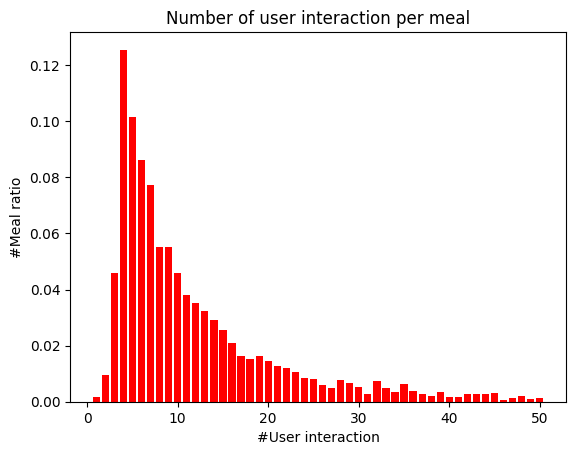

In [21]:
distUB = dataHistogram(user_meal, 'meal_id', num_bundles)
showHistogram(distUB, 0, 50, 'Number of user interaction per meal', '#User interaction', '#Meal ratio')

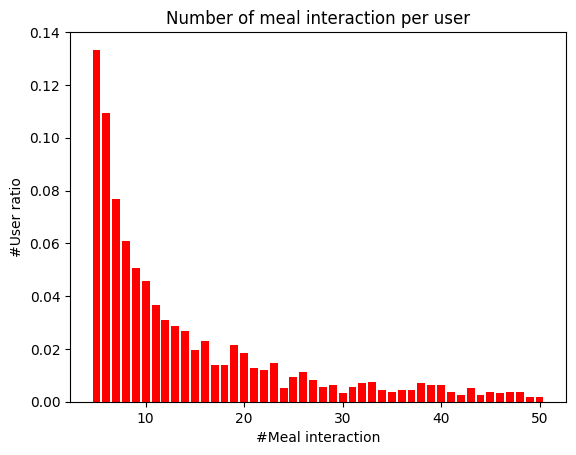

In [21]:
distBU = dataHistogram(user_meal, 'user_id', num_users)
showHistogram(distBU, 0, 50, 'Number of meal interaction per user', '#Meal interaction', '#User ratio')

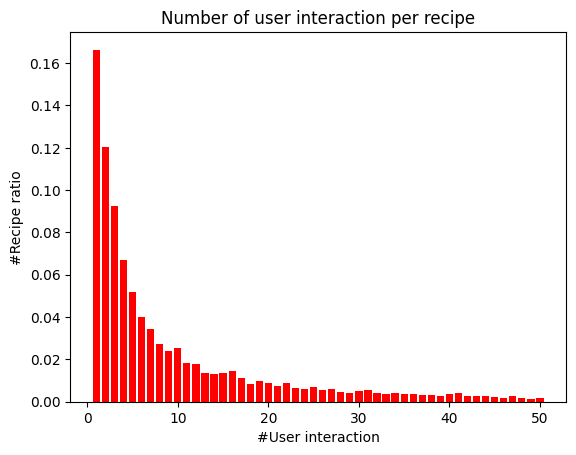

In [22]:
distUI = dataHistogram(user_recipe, 'recipe_id', num_items)
showHistogram(distUI, 0, 50, 'Number of user interaction per recipe', '#User interaction', '#Recipe ratio')

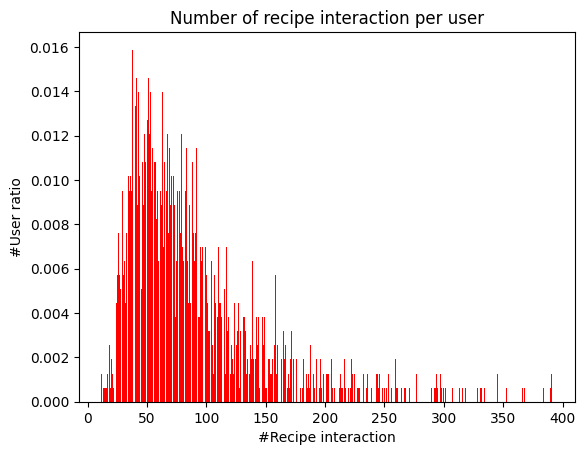

In [23]:
distIU = dataHistogram(user_recipe, 'user_id', num_users)
showHistogram(distIU, 0, 400, 'Number of recipe interaction per user', '#Recipe interaction', '#User ratio')

In [22]:
new_meal_table = pd.melt(meal_table, 'bundle_id', ['appetizer', 'main_dish', 'dessert'], value_name='recipe_id')
new_meal_table.drop('variable', axis=1, inplace=True)
new_meal_table.sort_values('bundle_id', inplace=True)
new_meal_table.reset_index(drop=True, inplace=True)
new_meal_table

,bundle_id,recipe_id
0,0,315
1,0,325
2,0,2211
3,1,1683
4,1,3328
...,...,...
11446,3815,1459
11447,3815,1962
11448,3816,1962
11449,3816,3504


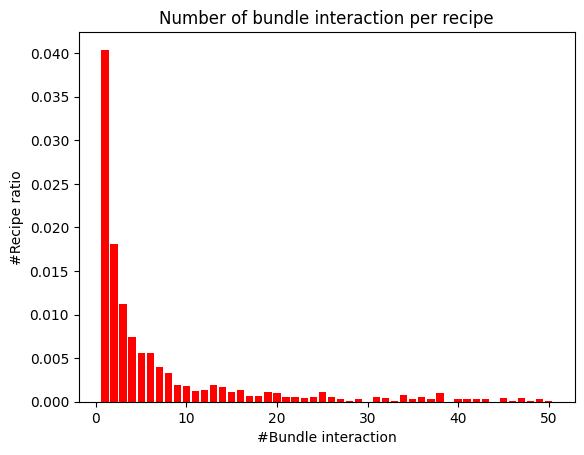

In [55]:
distBI = dataHistogram(new_meal_table, 'recipe_id', num_items)
showHistogram(distBI, 0, 50, 'Number of bundle interaction per recipe', '#Bundle interaction', '#Recipe ratio')

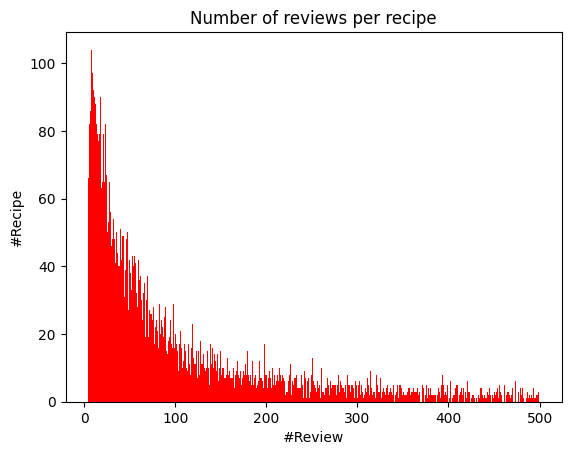

In [23]:
dist_review_nums = dataHistogram(recipe_table, 'review_nums', interaction=False)
showHistogram(dist_review_nums, 0, 500, 'Number of reviews per recipe', '#Review', '#Recipe', bar_width=1)

In [41]:
tag_stat = dict()
for tags in recipe_table['tags']:
    if type(tags) != float:
        tag_list = tags.split(';')
        for tag in tag_list:
            tag_stat[tag] = tag_stat[tag] + 1 if tag in tag_stat else 1

tag_stat = sortValue(tag_stat, reverse=True)

print(tag_stat)
print(len(tag_stat))

{'dietary': 5377, 'easy': 3876, 'low-in-something': 2781, 'main-dish': 2662, '60-minutes-or-less': 2396, 'equipment': 2346, 'meat': 2089, 'desserts': 1900, 'number-of-servings': 1742, '30-minutes-or-less': 1729, '4-hours-or-less': 1686, 'north-american': 1627, 'vegetables': 1615, 'taste-mood': 1615, 'low-carb': 1506, '3-steps-or-less': 1404, 'low-sodium': 1281, 'holiday-event': 1187, 'dinner-party': 1183, 'oven': 1132, 'low-calorie': 1111, 'healthy': 1107, 'american': 1072, 'beginner-cook': 1050, '15-minutes-or-less': 1046, 'low-cholesterol': 1004, 'poultry': 1004, 'low-protein': 952, 'appetizers': 948, 'eggs-dairy': 937, 'inexpensive': 925, 'kid-friendly': 916, '5-ingredients-or-less': 907, 'fruit': 883, 'comfort-food': 874, 'low-saturated-fat': 866, 'chicken': 857, 'vegetarian': 825, 'pasta-rice-and-grains': 807, 'weeknight': 801, 'presentation': 798, 'stove-top': 754, 'healthy-2': 744, 'seasonal': 728, 'european': 709, 'salads': 707, 'lunch': 685, 'to-go': 682, 'for-large-groups': 6

In [49]:
MAX_PLOT = 20
firstpairs = getTopElements(tag_stat, MAX_PLOT)
firstpairs

{'dietary': 5377,
 'easy': 3876,
 'low-in-something': 2781,
 'main-dish': 2662,
 '60-minutes-or-less': 2396,
 'equipment': 2346,
 'meat': 2089,
 'desserts': 1900,
 'number-of-servings': 1742,
 '30-minutes-or-less': 1729,
 '4-hours-or-less': 1686,
 'north-american': 1627,
 'vegetables': 1615,
 'taste-mood': 1615,
 'low-carb': 1506,
 '3-steps-or-less': 1404,
 'low-sodium': 1281,
 'holiday-event': 1187,
 'dinner-party': 1183,
 'oven': 1132}

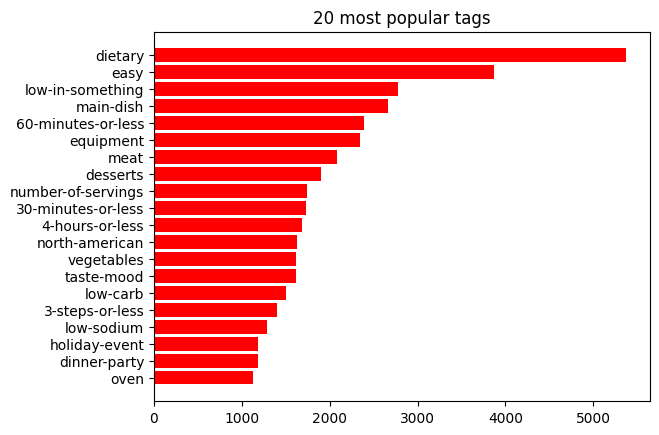

In [53]:
xvalue = list(firstpairs.keys())[::-1]
yvalue = list(firstpairs.values())[::-1]
plt.barh(xvalue, yvalue, color='r')
plt.title('20 most popular tags')
plt.show()

### 4. Image download

In [57]:
import requests

def download_image(url, file_path):
    response = requests.get(url)
    if response.status_code == 200:
        with open(file_path, "wb") as file:
            file.write(response.content)
        print(f"Image {file_path} downloaded successfully!")
    else:
        print("Failed to download image. Error:", response.status_code)

for idx in recipe_table.index:
    image_url = recipe_table['image_url'][idx]
    recipe_id = recipe_table['recipe_id'][idx]
    file_path = f'recipe_image/{recipe_id}.jpg'
    download_image(image_url, file_path)

Image recipe_image/0.jpg downloaded successfully!
Image recipe_image/1.jpg downloaded successfully!
Image recipe_image/2.jpg downloaded successfully!
Image recipe_image/3.jpg downloaded successfully!
Image recipe_image/4.jpg downloaded successfully!
Image recipe_image/5.jpg downloaded successfully!
Image recipe_image/6.jpg downloaded successfully!
Image recipe_image/7.jpg downloaded successfully!
Image recipe_image/8.jpg downloaded successfully!
Image recipe_image/9.jpg downloaded successfully!
Image recipe_image/10.jpg downloaded successfully!
Image recipe_image/11.jpg downloaded successfully!
Image recipe_image/12.jpg downloaded successfully!
Image recipe_image/13.jpg downloaded successfully!
Image recipe_image/14.jpg downloaded successfully!
Image recipe_image/15.jpg downloaded successfully!
Image recipe_image/16.jpg downloaded successfully!
Image recipe_image/17.jpg downloaded successfully!
Image recipe_image/18.jpg downloaded successfully!
Image recipe_image/19.jpg downloaded succ

### 5. Deeper statistics

In [24]:
def getMatrix(row, col, shape=None) -> coo_matrix:
    """
    Get sparse matrix from row indices and column indices
    """
    row_indices = list(row)
    col_indices = list(col)
    data = np.ones(len(row_indices))
    if shape == None: shape = (max(row_indices) + 1, max(col_indices) + 1)
    matrix = coo_matrix((data, (row_indices, col_indices)), shape=shape)
    return matrix

def cooccurence(matrix: coo_matrix):
    """
    Get co-occurence matrix from a sparse interaction matrix
    """
    return matrix.dot(matrix.transpose())

In [25]:
def cooccurenceHistogram(matrix: coo_matrix, ratio=True, self_coo=True):
    """
    Calculate the histogram of element appearances in a co-occurrence matrix.

    Args:
        matrix: sparse matrix (coo_matrix)
        ratio: True if the result is stored in distribution form.
        self_coo: True if consider a single element as a self-cooccurence pair (main diagonal of matrix)

    Returns:
        Histogram of co-occurence matrix (dict)
    """
    histogram = dict()
    for _, (row, col) in enumerate(zip(matrix.nonzero()[0], matrix.nonzero()[1])):
        condition = row <= col if self_coo else row < col
        if condition:
            value = int(matrix[row, col])
            histogram[value] = histogram[value] + 1 if value in histogram else 1
    if ratio:
        n = matrix.shape[0]
        total_element = n * (n - 1) / 2 if not self_coo else n * (n + 1) / 2
        for ele in histogram.keys():
            histogram[ele] /= total_element
    return sortKey(histogram)

In [44]:
def countNoInteraction(matrix: coo_matrix, axis=0):
    '''
    Count the number of elements with no interactions along an axis
    Axis = 0 means counting by column, axis = 1 means counting by row
    '''
    axis_sum = matrix.sum(axis=axis)
    count = (axis_sum == 0).sum()
    return count

#### 5.1. User-meal cooccurence analysis

In [28]:
UB_matrix = getMatrix(user_meal['user_id'], user_meal['meal_id'])
print(UB_matrix.shape)

(1575, 3817)


In [59]:
user_cooccurence_with_bundle = cooccurence(UB_matrix)
print(user_cooccurence_with_bundle.shape)

(1575, 1575)


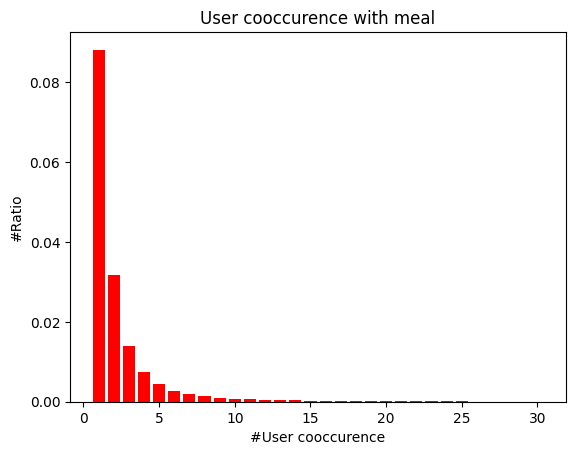

In [72]:
UB_coo_dist = cooccurenceHistogram(user_cooccurence_with_bundle, self_coo=False)
showHistogram(UB_coo_dist, 0, 30, 'User cooccurence with meal', '#User cooccurence', '#Ratio')

In [25]:
bundle_cooccurence_with_user = cooccurence(UB_matrix.transpose())
print(bundle_cooccurence_with_user.shape)

(3817, 3817)


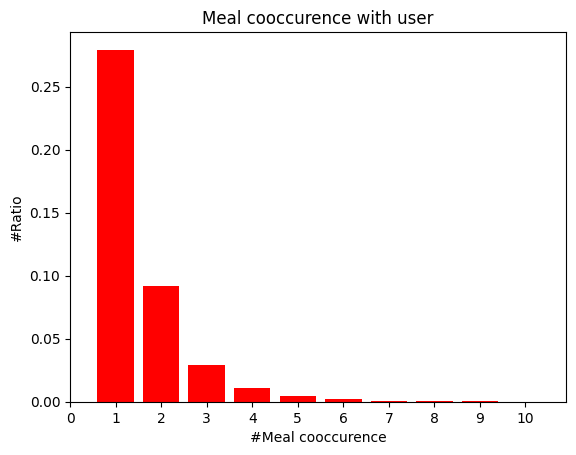

In [107]:
BU_coo_dist = cooccurenceHistogram(bundle_cooccurence_with_user, self_coo=False)
showHistogram(BU_coo_dist, 0, 10, 'Meal cooccurence with user', '#Meal cooccurence', '#Ratio')

#### 5.2. User-recipe cooccurence analysis

In [32]:
UI_matrix = getMatrix(user_recipe['user_id'], user_recipe['recipe_id'])
print(UI_matrix.shape)

(1575, 7280)


In [58]:
user_cooccurence_with_item = cooccurence(UI_matrix)
print(user_cooccurence_with_item.shape)

(1575, 1575)


In [77]:
UI_coo_dist = cooccurenceHistogram(user_cooccurence_with_item, self_coo=False)

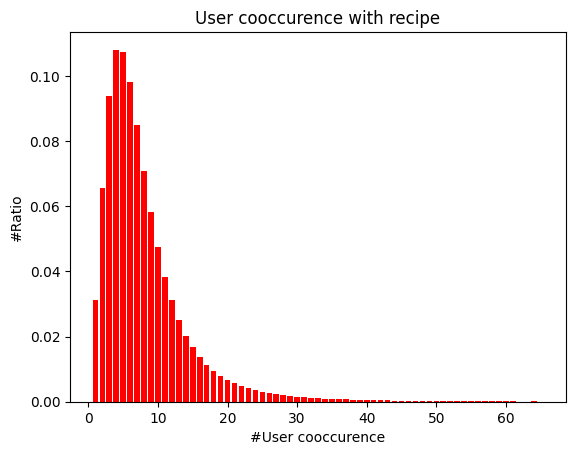

In [81]:
showHistogram(UI_coo_dist, 0, 65, 'User cooccurence with recipe', '#User cooccurence', '#Ratio')

In [28]:
item_cooccurence_with_user = cooccurence(UI_matrix.transpose())
print(item_cooccurence_with_user.shape)

(7280, 7280)


In [82]:
IU_coo_dist = cooccurenceHistogram(item_cooccurence_with_user, self_coo=False)

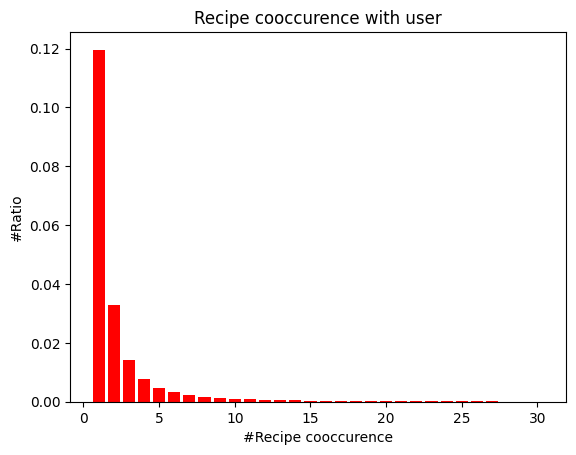

In [85]:
showHistogram(IU_coo_dist, 0, 30, 'Recipe cooccurence with user', '#Recipe cooccurence', '#Ratio')

#### 5.3. Meal-recipe cooccurence analysis

In [35]:
BI_matrix = getMatrix(new_meal_table['bundle_id'], new_meal_table['recipe_id'], shape=(num_bundles, num_items))
print(BI_matrix.shape)

(3817, 7280)


In [43]:
print(f'Percentage of recipe not appearing in any meal: {countNoInteraction(BI_matrix, 0) / (BI_matrix.shape[1]) * 100:.2f}%')

Percentage of recipe not appearing in any meal: 87.06%


In [33]:
bundle_cooccurence_with_item = cooccurence(BI_matrix)
print(bundle_cooccurence_with_item.shape)

(3817, 3817)


In [98]:
BI_coo_dist = cooccurenceHistogram(bundle_cooccurence_with_item, self_coo=False)

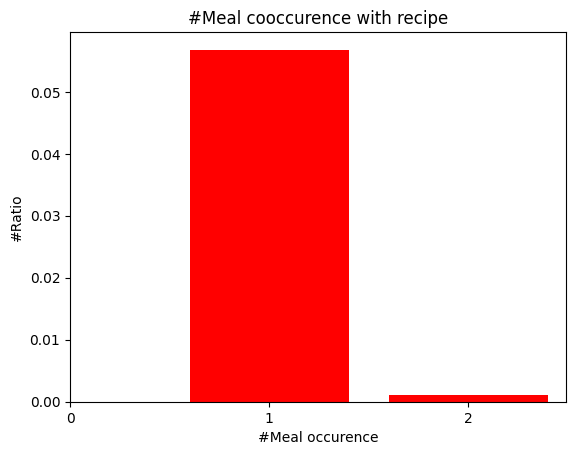

In [105]:
showHistogram(BI_coo_dist, 0, 2, '#Meal cooccurence with recipe', '#Meal occurence', '#Ratio')

In [34]:
item_cooccurence_with_bundle = cooccurence(BI_matrix.transpose())
print(item_cooccurence_with_bundle.shape)

(7280, 7280)


In [92]:
IB_coo_dist = cooccurenceHistogram(item_cooccurence_with_bundle, self_coo=False)

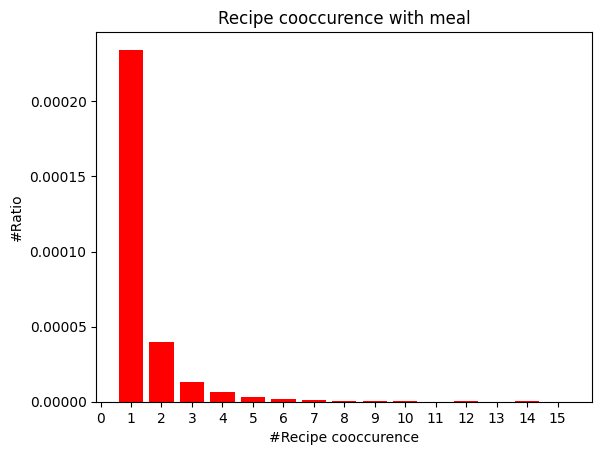

In [106]:
showHistogram(IB_coo_dist, 0, 15, 'Recipe cooccurence with meal', '#Recipe cooccurence', '#Ratio')

#### 5.4. c-score

In [64]:
def c_score(matrix_1: coo_matrix, matrix_2: coo_matrix, interaction=True):
    '''
    Calculate c-score (measure consistency between U-B and U-I collaborative relations)

    Args:
        interaction: 
            True: matrix_1 is UB matrix, matrix_2 is UI matrix.
            False: matrix_1 is user co-occurence matrix w.r.t bundle, matrix_2 is user co-occurence matrix w.r.t item.
    
    Returns:
        c-score: float
    '''
    if interaction:
        matrix_1 = cooccurence(matrix_1)
        matrix_2 = cooccurence(matrix_2)
    
    matrix_intersection = matrix_1.multiply(matrix_2)

    def count(matrix: coo_matrix):
        matrix.setdiag(0)
        nonzero_count = matrix.count_nonzero() / 2
        return nonzero_count
    
    size_bundle = count(matrix_1)
    size_item = count(matrix_2)
    size_intersection = count(matrix_intersection)

    c_score = 2 * size_intersection / (size_bundle + size_item)

    return c_score

In [69]:
print(f'c-score: {c_score(UB_matrix, UI_matrix):.4f}')

c-score: 0.2741
